In [15]:
import math
import pandas as pd
import tensorflow as tf
# import keras_tuner.tuners as kt
import matplotlib.pyplot as plt
import keras
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError
import numpy as np
import pickle
np.random.seed(0)
from tensorflow.keras import Input
from tensorflow.keras.layers import Conv1D, Conv2D, LeakyReLU, MaxPool1D, AveragePooling1D, UpSampling1D, Flatten, Dense, Reshape, BatchNormalization
# https://towardsdatascience.com/improve-your-model-performance-with-auto-encoders-d4ee543b4154
from tensorflow.keras import initializers
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from scipy.stats import multivariate_normal
from keras.optimizers import Adam, SGD, Adadelta
from kmeans_gmm_eval_fns import gmm_model_get_prediction_ae, gmm_model_get_prediction_pca
import objects


In [16]:
x_train_scaled = pd.read_csv('../data/260_sample_train_scaled.csv').set_index("Patient_ID")
x_train_scaled

,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,PPP1R17,WNT8A,LSM5,PCDHB3,GUSBP11,C16orf78,C5orf17,LOC100132831,LOC100288778,LOC100505851
Patient_ID,,,,,,,,,,,,,,,,,,,,,
55_control,0.702813,0.799052,0.719665,0.729547,0.794953,0.256451,1.000000,0.363133,0.374212,0.611161,...,0.932722,0.806913,0.653998,0.860533,0.837016,1.0,0.550415,0.000000,0.778617,0.940755
168_CD_plain,0.751408,0.603707,0.622768,0.627712,0.606860,0.520576,0.311962,0.251356,0.553554,0.441131,...,0.000000,0.000000,0.692339,0.578107,0.619998,0.0,0.000000,0.000000,0.607899,0.206271
72_control,0.786508,0.755331,0.739605,0.756170,0.819875,0.391132,0.648401,0.134017,0.200420,0.679453,...,0.000000,0.505180,0.644769,0.603195,0.756754,0.0,0.350566,0.000000,0.899508,0.014040
120_control,0.707491,0.662993,0.648072,0.764621,0.654276,0.633929,0.579519,0.248934,0.759250,0.755407,...,0.000000,0.000000,0.131632,0.053179,0.774455,0.0,0.000000,0.000000,0.528882,0.305806
258_CD_plain,0.701039,0.662511,0.707208,0.834562,0.670160,0.410612,0.370517,0.244987,0.445387,0.798000,...,0.000000,0.000000,0.085440,0.761822,0.860355,0.0,0.000000,0.000000,0.604102,0.014040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15_CD_plain,0.382762,0.384030,0.377332,0.360165,0.300915,0.340090,0.077348,0.890965,0.261140,0.205779,...,0.000000,0.000000,0.149005,0.740343,0.641698,0.0,0.000000,0.694951,0.485461,0.300471
182_CD_plain,0.679910,0.584723,0.722426,0.643867,0.740014,0.650358,0.468650,0.295686,0.649939,0.609862,...,0.000000,0.000000,0.229358,0.640000,0.731908,0.0,0.422815,0.096205,0.502320,0.615334
164_CD_plain,0.754656,0.556562,0.694062,0.748334,0.535534,0.133869,0.319071,0.154562,0.440487,0.824013,...,0.000000,0.000000,0.211405,0.797333,0.896369,0.0,0.234352,0.000000,0.496177,0.402714


In [17]:
x_test_scaled = pd.read_csv('../data/260_sample_test_scaled.csv').set_index("Patient_ID")
x_test_scaled

,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,PPP1R17,WNT8A,LSM5,PCDHB3,GUSBP11,C16orf78,C5orf17,LOC100132831,LOC100288778,LOC100505851
Patient_ID,,,,,,,,,,,,,,,,,,,,,
253_CD_plain,0.869185,0.841880,0.930171,0.886737,0.835678,0.297964,0.668498,0.266670,0.278122,0.933520,...,0.00000,0.0,0.016890,0.754178,0.816832,0.0,0.214180,0.000000,0.627881,0.014040
105_CD_plain,0.853562,0.933532,0.942213,0.794578,0.890482,0.206529,0.298987,0.350745,0.495663,0.849038,...,0.00000,0.0,0.380373,0.659297,0.789071,0.0,0.000000,0.296100,0.763348,0.354178
2_CD_plain,0.165531,0.141475,0.263684,0.198091,0.160503,0.888878,0.000000,0.134461,0.989132,0.202203,...,0.68115,0.0,0.127947,1.009412,0.582660,0.0,0.000000,0.473139,0.277717,0.014040
184_CD_plain,0.717121,0.660314,0.769417,0.752737,0.694874,0.514735,0.692365,0.271127,0.650742,0.694599,...,0.00000,0.0,0.203518,0.723574,0.696147,0.0,0.000000,0.000000,0.646765,0.450394
312_CD_plain,0.730072,0.722909,0.713076,0.743545,0.679258,0.308459,0.399235,0.129019,0.597529,0.720390,...,0.00000,0.0,0.214416,0.496175,0.803259,0.0,0.236722,0.000000,0.534480,0.304870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107_CD_plain,0.736123,0.658232,0.772323,0.685637,0.658755,0.250970,0.247307,0.422075,0.555944,0.603675,...,0.00000,0.0,0.357494,0.782257,0.591442,0.0,0.000000,0.431213,0.465159,0.540147
279_CD_plain,0.220614,0.202090,0.182810,0.113245,0.105744,0.699851,0.000000,0.908485,0.688912,0.178259,...,0.00000,0.0,0.418615,0.949858,0.559052,0.0,0.269991,0.410777,0.361163,0.561191
179_CD_plain,0.724476,0.726774,0.766943,0.776284,0.690339,0.380637,0.440449,0.318944,0.558600,0.738787,...,0.00000,0.0,0.105689,0.683222,0.878635,0.0,0.182111,0.650452,0.568842,0.398252


In [18]:
patient_ids_train = np.array(x_train_scaled.index)
patient_ids_test = np.array(x_test_scaled.index)
patient_ids_train

array(['55_control', '168_CD_plain', '72_control', '120_control',
       '258_CD_plain', '254_CD_deep_ulcer', '9_CD_plain', '111_CD_plain',
       '57_CD_plain', '216_CD_deep_ulcer', '263_CD_deep_ulcer',
       '95_CD_deep_ulcer', '31_control', '172_CD_plain', '310_CD_plain',
       '68_CD_plain', '65_control', '285_CD_plain', '201_CD_plain',
       '223_CD_deep_ulcer', '320_CD_plain', '8_CD_plain',
       '99_CD_deep_ulcer', '90_control', '296_CD_deep_ulcer',
       '219_CD_deep_ulcer', '138_CD_deep_ulcer', '38_control',
       '113_CD_plain', '76_control', '146_CD_deep_ulcer',
       '147_CD_deep_ulcer', '186_CD_plain', '158_CD_plain',
       '299_CD_plain', '178_CD_plain', '189_CD_plain', '266_CD_plain',
       '231_CD_deep_ulcer', '198_CD_plain', '6_CD_deep_ulcer',
       '30_CD_plain', '265_CD_plain', '181_CD_deep_ulcer', '16_CD_plain',
       '264_CD_deep_ulcer', '209_CD_plain', '83_control', '214_CD_plain',
       '193_CD_deep_ulcer', '104_CD_plain', '66_CD_plain', '188_CD_plain

In [19]:
def classify(x):
    if "_control" in x: # control
        return 0
    elif "CD_plain" in x: # Crohn's Disease no deep ulcer
#         print(x)
        return 1
    elif "CD_deep_ulcer" in x: # Crohn's Disease deep ulcer
#         print(x)
        return 2
    else:
        return 3 # Ulcerative Collitis

vec = np.vectorize(classify)

disease_labels_train = vec(patient_ids_train)
disease_labels_test = vec(patient_ids_test)
disease_labels_train

array([0, 1, 0, 0, 1, 2, 1, 1, 1, 2, 2, 2, 0, 1, 1, 1, 0, 1, 1, 2, 1, 1,
       2, 0, 2, 2, 2, 0, 1, 0, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2,
       1, 2, 1, 0, 1, 2, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1,
       1, 1, 2, 2, 2, 1, 0, 0, 0, 1, 2, 2, 2, 1, 1, 2, 1, 2, 1, 0, 1, 2,
       1, 2, 0, 0, 1, 2, 2, 1, 1, 2, 2, 0, 1, 2, 1, 2, 1, 0, 2, 1, 1, 1,
       2, 1, 1, 1, 1, 2, 1, 1, 1, 0, 1, 0, 1, 1, 0, 2, 2, 2, 0, 1, 1, 2,
       2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 0, 1, 1, 1, 1, 2, 1, 1,
       1, 2, 1, 1, 0, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 2, 0,
       0, 1, 1, 1, 1, 1])

In [20]:
# compound_model = keras.models.load_model('cd_clf')

In [21]:
# compound_model.summary()

## SHAP evaluation

In [22]:
x_test_scaled.iloc[:2,:2]

,AADAC,APOA1
Patient_ID,,
253_CD_plain,0.869185,0.841880
105_CD_plain,0.853562,0.933532


In [23]:
import objects

In [24]:
explainer = objects.get_explainer(model=gmm_model_get_prediction_ae, data=x_train_scaled, link="logit", feature_dependence=True)

getting explainerinitialising explainer


Using 182 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


link.f
link.f
link.f
link.f


## Calculate SHAP values

In [25]:
# shap_values = explainer.shap_values(X=x_test_scaled)

In [26]:
# shap_values

## Save SHAP values

In [27]:
# with open("shap_values", "wb") as fp:   #Pickling
#     pickle.dump(shap_values, fp)

In [28]:


with open("../data/models/shap/all_dep_2p11_2_mean", "rb") as fp:   # Unpickling
# with open("../shap_values", "rb") as fp:   # Unpickling
    shap_values = pickle.load(fp)

In [29]:
shap_values = shap_values[0]


In [30]:
# for i in range(3):
#     shap_values[i] /= 100

In [31]:
shap_values

[array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         -2.30298594,  0.        ],
        [ 0.        ,  0.        ,  0.        , ..., -7.44471494,
          4.75557128,  0.        ],
        [-3.91664476,  3.23461283, -3.08958172, ...,  1.88225887,
          5.66606388,  3.8990831 ]]),
 array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [-4.94577603, -5.1417412 ,  0.        , ...,  

In [32]:
print(f'length of SHAP values: {len(shap_values)}')
print(f'Shape of each element: {shap_values[0].shape}')

length of SHAP values: 3
Shape of each element: (78, 221)


Target Classes:
0: control
1: CD no ulcer
2: CD deep ulcer

## Patient-specific plots

In [33]:
idx = 41
patient = x_test_scaled.iloc[[idx],:]
patient

,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,PPP1R17,WNT8A,LSM5,PCDHB3,GUSBP11,C16orf78,C5orf17,LOC100132831,LOC100288778,LOC100505851
Patient_ID,,,,,,,,,,,,,,,,,,,,,
260_CD_deep_ulcer,0.588189,0.625309,0.750597,0.746795,0.678619,0.578012,0.191236,0.321755,0.595506,0.569387,...,0.0,0.0,0.155668,0.723766,0.785738,0.0,0.0,0.236732,0.678505,0.727315


In [34]:
gmm_model_get_prediction_ae(patient)[0]

array([2.10208717e-56, 1.38514946e-01, 8.61485054e-01])

In [35]:
print(f'Prediction probabilities for patient: {gmm_model_get_prediction_ae(patient)[0]}')
print("Predicted class:",np.argmax(gmm_model_get_prediction_ae(patient)[0]))

Prediction probabilities for patient: [2.10208717e-56 1.38514946e-01 8.61485054e-01]
Predicted class: 2


#### Control

In [36]:
import shap

In [37]:

shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][idx,:], patient, link="logit")

####  CD no ulcer

In [38]:

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][idx,:], patient, link="logit")

####  CD deep ulcer

In [39]:

shap.initjs()
shap.force_plot(explainer.expected_value[2], shap_values[2][idx,:], patient, link="logit")

In [40]:
# gene_shap.plots.bar(Explanation(x_test_scaled)[0], clustering=clustering)
idx = 18
explanation = objects.get_explanation(values=shap_values[2][idx], 
                                              base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
                                         feature_names=x_test_scaled.columns.tolist())

type(explanation)

getting explanation


_explanation.Explanation

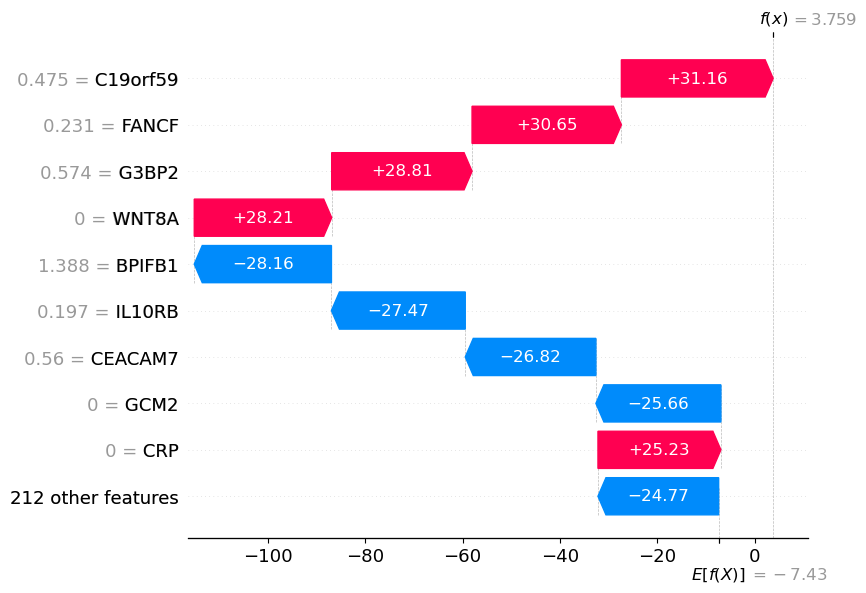

In [41]:
shap.waterfall_plot(explanation)
# shap.waterfall_plot(gene_shap.Explanation(values=shap_values[2][idx], 
#                                               base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
#                                          feature_names=x_test_scaled.columns.tolist()))

#### Control

In [42]:
# shap.initjs()
# shap.force_plot(explainer.expected_value[0], shap_values[0], x_test_scaled)

####  CD no ulcer

In [43]:
# shap.initjs()
# shap.force_plot(explainer.expected_value[1], shap_values[1], x_test_scaled)

####  CD deep ulcer

In [44]:
# shap.initjs()
# shap.force_plot(explainer.expected_value[2], shap_values[2], x_test_scaled)

## SHAP Summary Plots

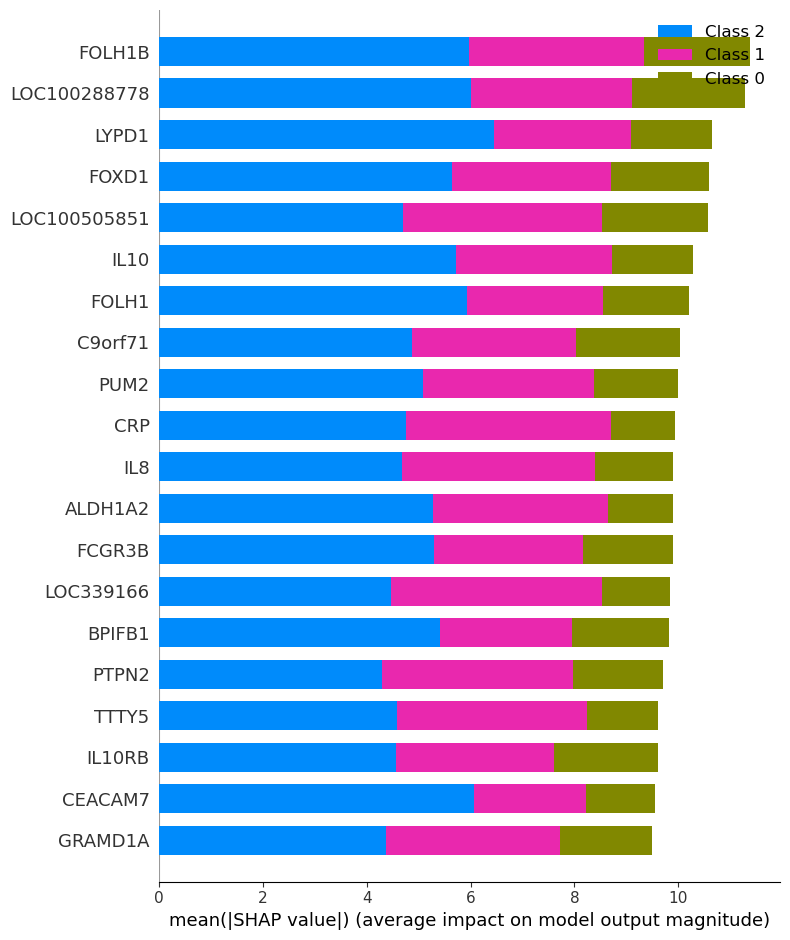

In [45]:
shap.summary_plot(shap_values, x_test_scaled)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


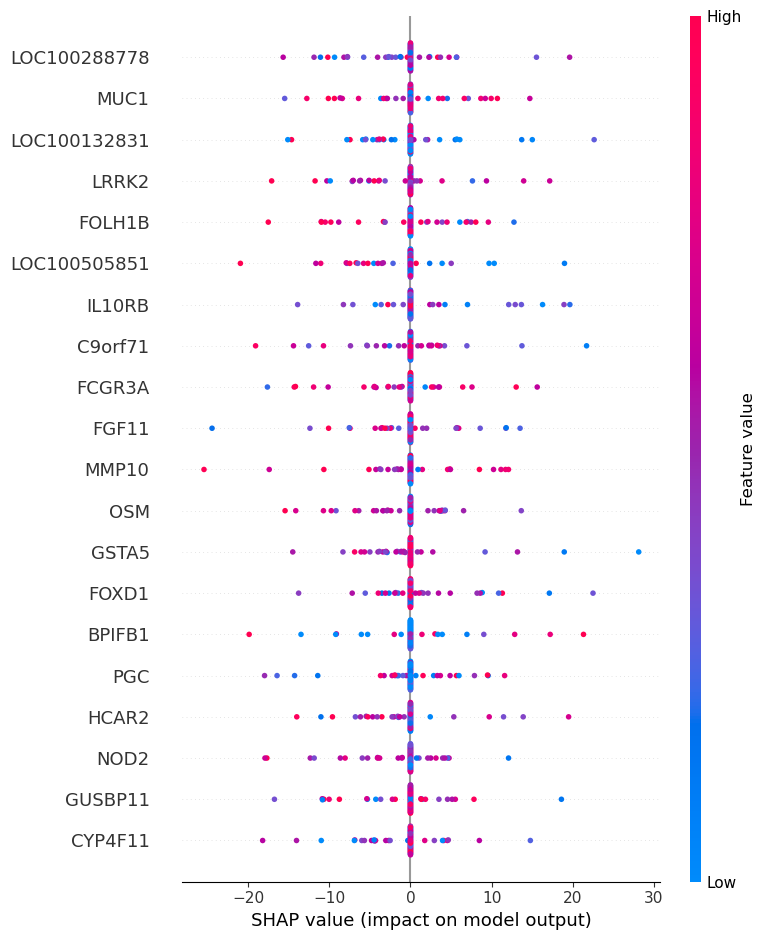

In [46]:
# control
shap.summary_plot(shap_values[0], x_test_scaled)

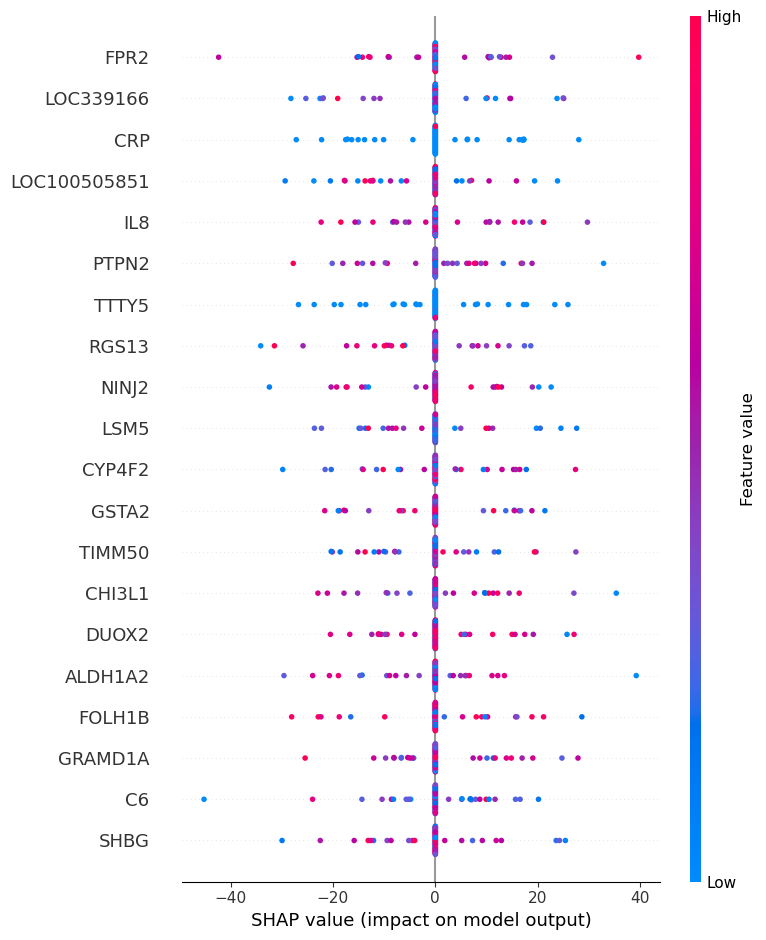

In [47]:
# CD no ulcer
shap.summary_plot(shap_values[1], x_test_scaled)

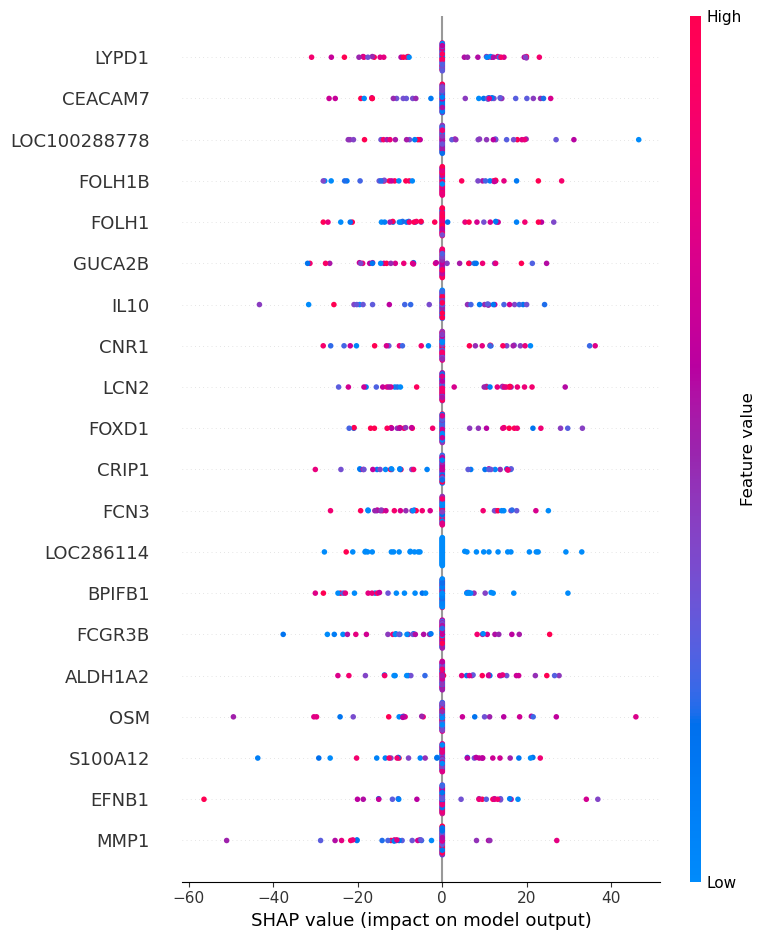

In [48]:
# CD deep ulcer
shap.summary_plot(shap_values[2], x_test_scaled)

## SHAP Dependence Plots

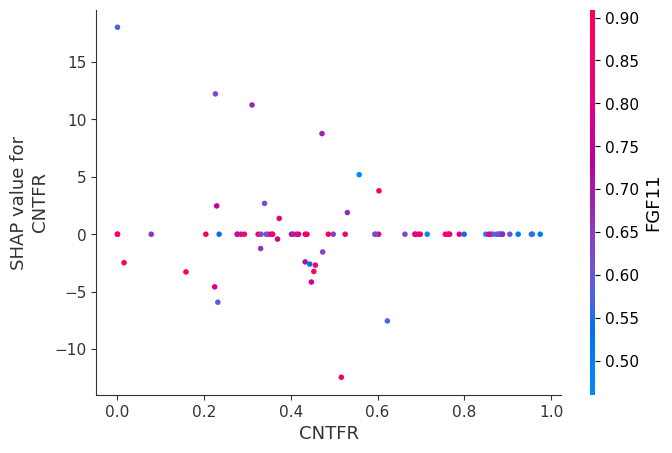

In [49]:
# control
shap.dependence_plot("CNTFR", shap_values[0], x_test_scaled)

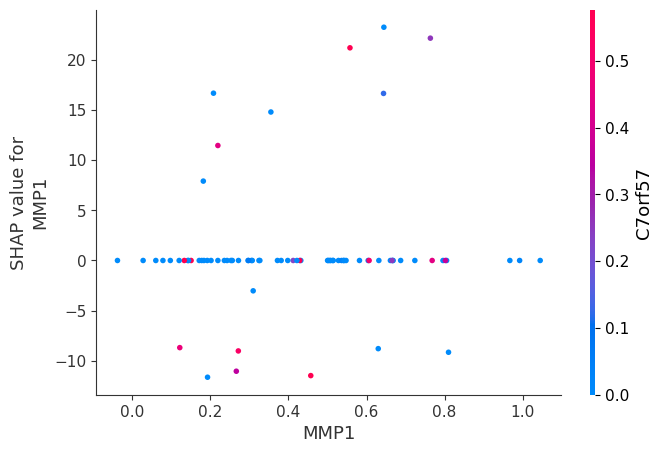

In [50]:
# CD no ulcer
shap.dependence_plot("MMP1", shap_values[1], x_test_scaled)

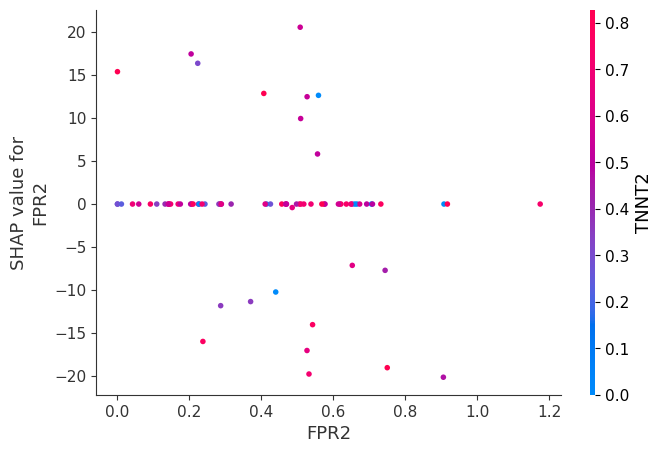

In [51]:
# CD deep ulcer
shap.dependence_plot("FPR2",shap_values[2], x_test_scaled)

## Clustering

In [52]:
disease_labels_test.shape

(78,)

In [53]:
# sys.stdout = open(1, 'w')
import sys
stdout = sys.stdout
sys.stdout = sys.__stdout__

### Current SHAP functionality

In [54]:
clustering = objects.get_clustering(x_test_scaled, disease_labels_test)

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
No/low signal found from feature 13 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).
 96%|█████████████████████████████████████████████████████████████████████████████   | 213/221 [01:28<00:02,  3.02it/s]No/low signal found from feature 212 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).
222it [01:32,  2.16it/s]                                                                                               


In [55]:
# clustering

In [56]:
# clustering.shape

In [57]:
row = 77
exp = shap.Explanation(values=shap_values[2][row], base_values=explainer.expected_value[2], 
                                data=x_test_scaled.iloc[row], feature_names=x_test_scaled.columns.tolist())

# patient 8: explanations for CD deep ulcer diagnosis

In [58]:
type(exp)

shap._explanation.Explanation

In [59]:
# with open("clust", "wb") as fp:   #Pickling
#     pickle.dump(clustering, fp)

In [60]:

# with open("../clust", "rb") as fp:   # Unpickling
#     clustering = pickle.load(fp)

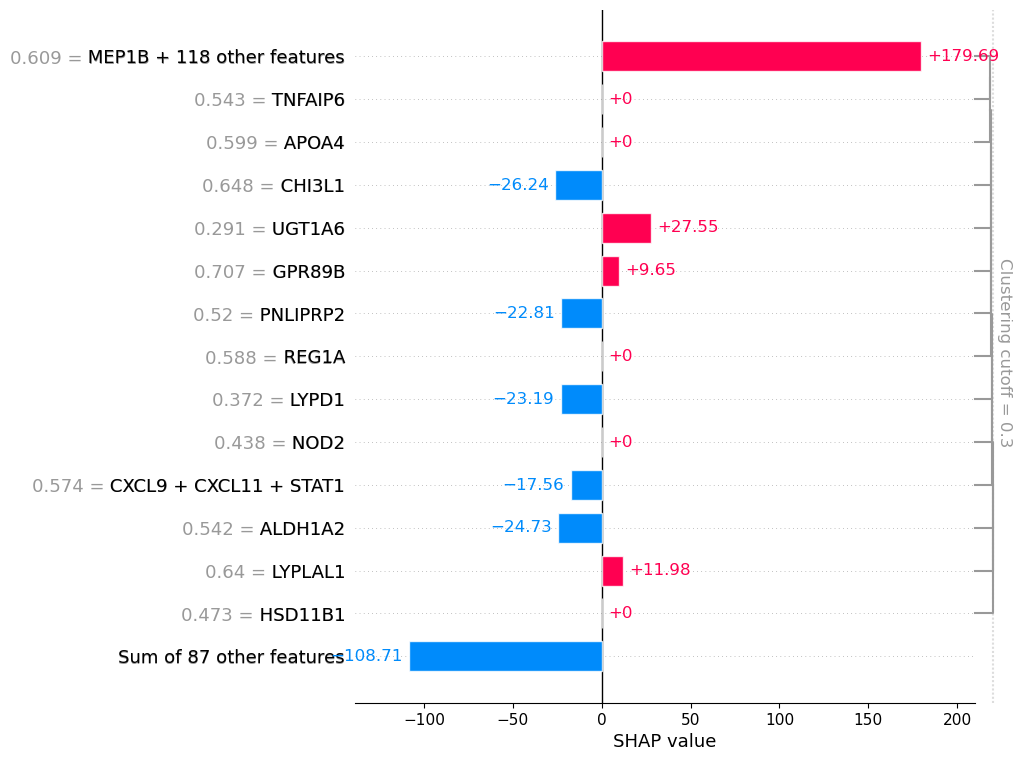

In [61]:
import shap
# shap.plots.bar(explanation, clustering=clustering)
shap.plots.bar(exp, max_display=15, clustering_cutoff=0.3,
               clustering=clustering)

## Hierarchical clustering of genes based on shap values, across all patients with given disease classification

In [62]:
from scipy.cluster.hierarchy import dendrogram, linkage, leaders, fcluster
import seaborn as sns

In [63]:


all_gene_df = pd.DataFrame(shap_values[2], index=x_test_scaled.index, columns = x_test_scaled.columns)
df_cd_deep = all_gene_df[all_gene_df.index.str.endswith('_CD_deep_ulcer')]
df_cd_plain = all_gene_df[all_gene_df.index.str.endswith('_CD_plain')]
df_control = all_gene_df[all_gene_df.index.str.endswith('_control')]
df_cd_deep

,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,PPP1R17,WNT8A,LSM5,PCDHB3,GUSBP11,C16orf78,C5orf17,LOC100132831,LOC100288778,LOC100505851
Patient_ID,,,,,,,,,,,,,,,,,,,,,
62_CD_deep_ulcer,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
167_CD_deep_ulcer,0.000000,0.000000,0.000000,0.000000,10.034131,17.181726,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.572630,0.000000
196_CD_deep_ulcer,-10.478885,-14.349854,0.000000,0.000000,-21.316697,-17.262368,0.000000,-25.353094,0.000000,10.424948,...,0.000000,0.000000,0.000000,0.000000,0.000000,13.767623,15.728981,5.730308,-7.766724,13.676426
23_CD_deep_ulcer,0.000000,9.712183,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
93_CD_deep_ulcer,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
229_CD_deep_ulcer,0.000000,0.000000,-12.755264,-8.197881,0.000000,11.225725,11.926478,0.000000,0.000000,0.000000,...,-11.138119,0.000000,0.000000,14.938758,0.000000,0.000000,4.541799,-11.641026,0.000000,0.000000
46_CD_deep_ulcer,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-26.815984,0.000000,0.000000,...,0.000000,28.209829,0.000000,0.000000,0.000000,0.000000,0.000000,-14.530804,0.000000,0.000000
176_CD_deep_ulcer,8.312236,0.000000,0.000000,-2.324736,0.000000,0.000000,11.319570,-10.823799,0.000000,0.000000,...,0.000000,11.182773,0.000000,0.000000,0.000000,0.000000,17.451252,0.000000,3.004134,0.000000
49_CD_deep_ulcer,0.000000,0.000000,-23.391928,11.821624,0.000000,0.000000,0.000000,-16.573676,0.000000,0.000000,...,-9.381762,9.806639,0.000000,0.000000,-33.533678,0.000000,0.000000,0.000000,8.813460,0.000000


### Example: CD deep ulcer patients

In [64]:
# patient_cluster_cd_deep = linkage(df_cd_deep, 'ward', metric='euclidean', optimal_ordering=True)
gene_cluster_cd_deep = linkage(df_cd_deep.T, 'ward', metric='euclidean', optimal_ordering=True)

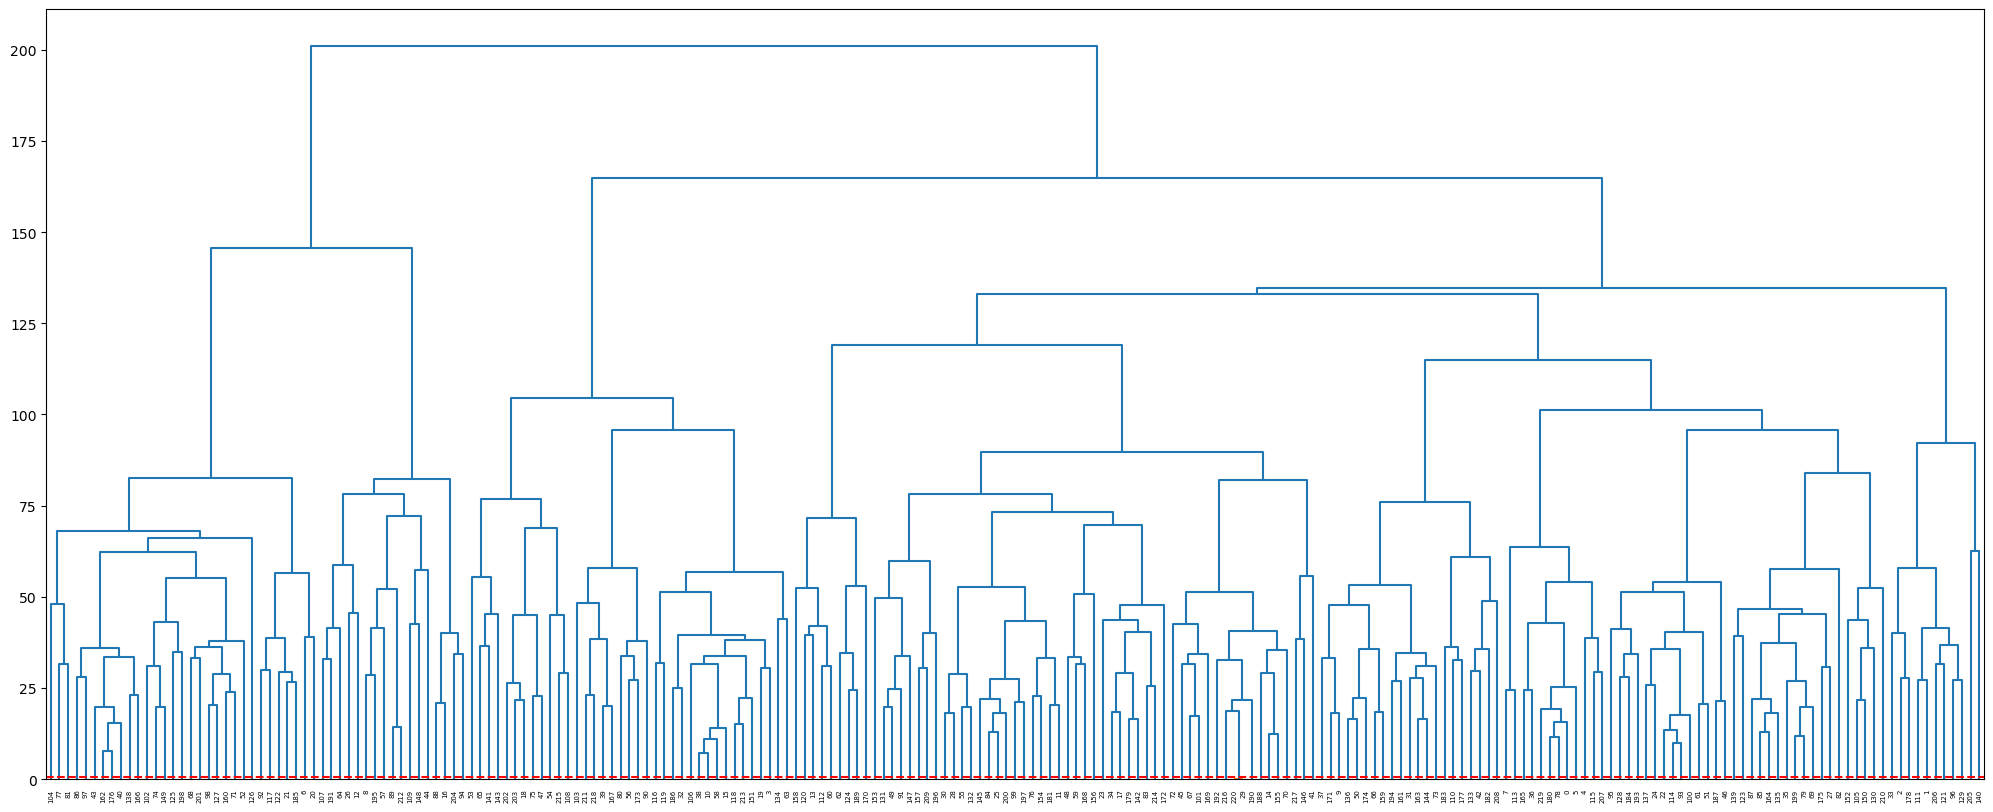

In [65]:

fig = plt.figure(figsize=(25, 10))
dn = dendrogram(gene_cluster_cd_deep, color_threshold = .7, get_leaves=True)
# dn = dendrogram(fl)
plt.axhline(y=.7, c='r', linestyle='--')

In [66]:
dn_ids = np.asarray(dn['ivl'], dtype='int')
dn_ids

array([104,  77,  81,  86,  97,  43, 162, 176,  40, 138, 166, 102,  74,
       149, 125, 198,  68, 201,  98, 127, 160,  71,  52, 126,  92, 117,
       122,  21, 185,   6,  20, 107, 191,  64,  26,  12,   8, 195,  57,
        89, 212, 109, 148,  44,  88,  16, 204,  94,  53,  65, 141, 143,
       202, 203,  18,  75,  47,  54, 215, 108, 103, 211, 218,  39, 167,
        80,  56, 173,  90, 116, 119, 186,  32, 106,  38,  10,  58,  15,
       118, 213, 151,  19,   3, 134,  63, 158, 120,  13, 112,  60,  62,
       124, 189, 170, 153, 131,  49,  91, 147, 157, 209, 196,  30,  28,
        55, 132, 145,  84,  25, 200,  99, 197,  76, 154, 181,  11,  48,
        59, 168, 156,  23,  34,  17, 179, 142,  83, 214, 172,  72,  45,
        67, 101, 169, 192, 216, 220,  29, 190, 188,  14, 155,  70, 217,
       146,  41,  37, 171,   9, 136,  50, 174,  66, 159, 194, 161,  31,
       163, 144,  73, 183, 110, 177, 133,  42, 182, 208,   7, 113, 165,
        36, 219, 180,  78,   0,   5,   4, 115, 207,  95, 128, 18

In [67]:
df_cd_deep.columns

Index(['AADAC', 'APOA1', 'APOA4', 'APOB', 'APOC3', 'AQP9', 'C6', 'CEACAM7',
       'CHI3L1', 'ABCC2',
       ...
       'PPP1R17', 'WNT8A', 'LSM5', 'PCDHB3', 'GUSBP11', 'C16orf78', 'C5orf17',
       'LOC100132831', 'LOC100288778', 'LOC100505851'],
      dtype='object', length=221)

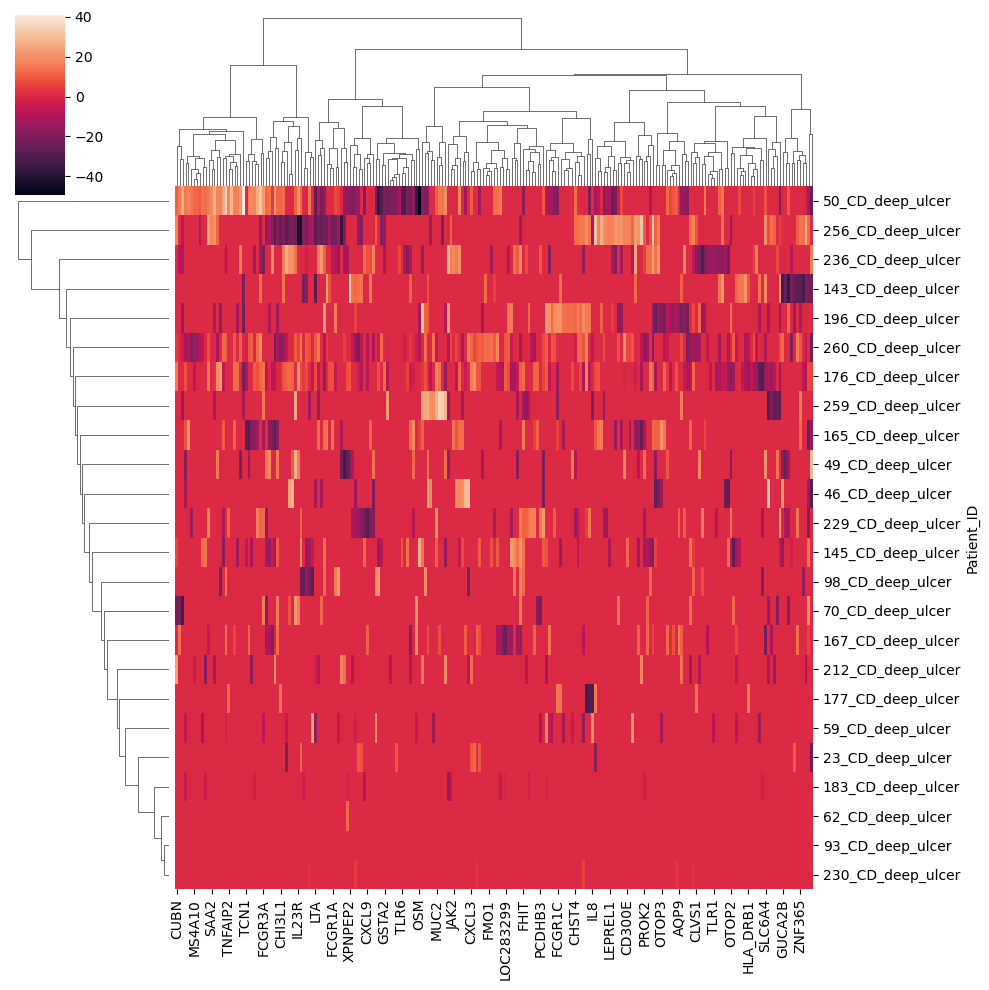

In [68]:
# shap values across genes (CD deep ulcer) - shows contribution of genes to disease symptom prediction for patients with given symptoms

# g = sns.clustermap(df_cd_deep, col_linkage=gc, row_linkage=patient_cluster_cd_deep)
g = sns.clustermap(df_cd_deep, col_linkage=gene_cluster_cd_deep)

## Aggregate bar plot, showing possible gene modules alongside SHAP contributions

In [69]:
gene_cluster_cd_deep

array([[2.20000000e+02, 2.90000000e+01, 1.52573641e-01, 2.00000000e+00],
       [3.80000000e+01, 1.00000000e+01, 7.19576214e+00, 2.00000000e+00],
       [1.62000000e+02, 1.76000000e+02, 7.70661524e+00, 2.00000000e+00],
       [1.14000000e+02, 9.30000000e+01, 9.87469454e+00, 2.00000000e+00],
       [2.22000000e+02, 5.80000000e+01, 1.08962646e+01, 3.00000000e+00],
       [1.80000000e+02, 7.80000000e+01, 1.15118665e+01, 2.00000000e+00],
       [1.99000000e+02, 7.90000000e+01, 1.18989884e+01, 2.00000000e+00],
       [1.40000000e+01, 1.55000000e+02, 1.24462885e+01, 2.00000000e+00],
       [8.40000000e+01, 2.50000000e+01, 1.27938677e+01, 2.00000000e+00],
       [8.50000000e+01, 1.64000000e+02, 1.30640479e+01, 2.00000000e+00],
       [2.20000000e+01, 2.24000000e+02, 1.36083349e+01, 3.00000000e+00],
       [2.25000000e+02, 1.50000000e+01, 1.41337357e+01, 4.00000000e+00],
       [8.90000000e+01, 2.12000000e+02, 1.43427972e+01, 2.00000000e+00],
       [1.18000000e+02, 2.13000000e+02, 1.50730222e

In [70]:
cluster_labels = fcluster(gene_cluster_cd_deep, .7, criterion='distance')
# label = fcluster(gene_cluster_cd_deep, 8, criterion='maxclust')
cluster_labels.shape

(221,)

In [71]:
leaders(gene_cluster_cd_deep, cluster_labels)

(array([ 77,  81, 104,  86,  97, 162, 176,  40,  43, 138, 166,  74, 149,
        102, 125, 198,  68, 201,  98, 127, 160,  71,  52, 126,  92, 117,
         21, 185, 122,   6,  20, 107, 191,  64,  26,  12,   8, 195,  57,
         89, 212, 109, 148,  44,  88,  16, 204,  94,  65, 141, 143,  53,
        203,  18, 202,  75,  47, 215, 108,  54, 211, 218,  39, 167, 103,
         56, 173,  80,  90, 116, 119, 186,  32,  38,  10,  58,  15, 106,
        118, 213, 151,  19,   3, 134,  63, 120,  13, 112,  60, 158, 124,
        189,  62, 170, 131,  49,  91, 147, 153, 157, 209, 196,  30,  28,
         55, 132,  84,  25, 200, 145,  99, 197,  76, 154, 181,  11,  59,
        168,  48, 156,  34,  17, 179, 142,  83, 214,  23, 172,  67, 101,
         45, 169,  72, 216, 221, 190, 192,  14, 155, 188,  70, 217, 146,
         41, 171,   9,  37, 136,  50, 174,  66, 159, 194, 161, 163, 144,
         31,  73, 110, 177, 183, 133,  42, 182, 208,   7, 113, 165,  36,
        180,  78,   0, 219,   5, 115, 207,   4, 128

In [72]:
leader_ids = leaders(gene_cluster_cd_deep, cluster_labels)[1]
leader_ids

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 135, 134, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [73]:
cluster_labels

array([172, 214, 210,  83, 177, 174,  30, 166,  37, 146,  75, 116,  36,
        87, 138,  77,  46, 122,  54,  82,  31,  27, 186, 127, 183, 108,
        35, 203, 104, 134, 103, 157,  73, 212, 121, 201, 169, 147,  74,
        63,   8, 144, 163,   9,  44, 131, 191,  57, 119,  96, 149, 189,
        23,  52,  60, 105,  66,  39,  76, 117,  89, 188,  93,  85,  34,
        49, 151, 129,  17, 200, 141,  22, 133, 158,  12,  56, 113,   1,
       171, 199,  68,   2, 204, 125, 107, 194,   4, 197,  45,  40,  69,
        97,  25, 185,  48, 181, 217,   5,  19, 111, 187, 130,  14,  65,
         3, 205,  78,  32,  59,  42, 159, 213,  88, 167, 184, 175,  70,
        26,  79,  71,  86, 216,  29, 193,  91,  15,  24,  20, 178, 218,
       207,  95, 106, 162,  84, 196, 148, 182,  10, 192, 220,  50, 124,
        51, 156, 110, 143,  98,  43,  13, 206,  81, 208,  99, 114, 139,
       120, 100,  90, 152,  21, 154,   6, 155, 195, 168,  11,  64, 118,
       132,  94, 145, 128,  67, 150, 202,   7, 160, 211, 123, 17

In [74]:
df_cd_deep.columns.get_loc("OSM")

63

In [75]:
np.where(cluster_labels == 2) #osm

(array([81], dtype=int64),)

In [76]:
gene_df = df_cd_deep.describe().T
gene_df['gene_symbol']  = df_cd_deep.columns
gene_df["group_num"] = cluster_labels

gene_df

,count,mean,std,min,25%,50%,75%,max,gene_symbol,group_num
AADAC,24.0,0.473526,3.594213,-10.478885,0.0,0.0,0.0,10.769125,AADAC,172
APOA1,24.0,-1.253791,6.291428,-25.453302,0.0,0.0,0.0,9.712183,APOA1,214
APOA4,24.0,-2.554816,7.182942,-25.168395,0.0,0.0,0.0,0.000000,APOA4,210
APOB,24.0,0.160320,6.101892,-16.633330,0.0,0.0,0.0,19.182014,APOB,83
APOC3,24.0,0.899182,7.824873,-21.316697,0.0,0.0,0.0,16.670199,APOC3,177
...,...,...,...,...,...,...,...,...,...,...
C16orf78,24.0,-0.374039,4.407258,-12.347759,0.0,0.0,0.0,13.767623,C16orf78,135
C5orf17,24.0,1.755429,10.158090,-33.811086,0.0,0.0,0.0,19.861056,C5orf17,142
LOC100132831,24.0,-1.624706,6.508199,-16.777472,0.0,0.0,0.0,11.778129,LOC100132831,62
LOC100288778,24.0,1.001527,4.514128,-7.766724,0.0,0.0,0.0,12.655876,LOC100288778,173


In [77]:
# mean_df = gene_df[['mean','group_num']]
mean_df = gene_df[['mean','group_num','gene_symbol']]
mean_df

,mean,group_num,gene_symbol
AADAC,0.473526,172,AADAC
APOA1,-1.253791,214,APOA1
APOA4,-2.554816,210,APOA4
APOB,0.160320,83,APOB
APOC3,0.899182,177,APOC3
...,...,...,...
C16orf78,-0.374039,135,C16orf78
C5orf17,1.755429,142,C5orf17
LOC100132831,-1.624706,62,LOC100132831
LOC100288778,1.001527,173,LOC100288778


In [78]:

mean_df["gene_symbol"] = mean_df.index
mean_df


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,mean,group_num,gene_symbol
AADAC,0.473526,172,AADAC
APOA1,-1.253791,214,APOA1
APOA4,-2.554816,210,APOA4
APOB,0.160320,83,APOB
APOC3,0.899182,177,APOC3
...,...,...,...
C16orf78,-0.374039,135,C16orf78
C5orf17,1.755429,142,C5orf17
LOC100132831,-1.624706,62,LOC100132831
LOC100288778,1.001527,173,LOC100288778


In [79]:
def group_labels(x):
    if len(x) > 4:
        gene_list = x[:4]
    else:
        gene_list = x
    return ", ".join(gene_list)

def add_other(num, curr_label, max_display=4):
#     print(type(num))
#     print(type(curr_label))
    if num > 1:
        if num > 2: 
            other = " others" 
            num_displayed = min(num, max_display)
        else:
            num_displayed = 2
            other = " other"
        rem = num - num_displayed
        if rem == 0:
            return curr_label
        return curr_label + " + " + str(rem) + other
    else:
        return curr_label


In [80]:

def get_idx_order(dn_ids, df, agg_df):
    g_symbols = np.array(df.columns)
    g_symbols = g_symbols[dn_ids]
    
    genes_from_groups = []
    for li in agg_df["grouped_genes"].values:
        genes_from_groups.append(li[0])
        
    positions_in_dend = [np.where(g_symbols == gene)[0][0] for gene in genes_from_groups]
    idxs = np.arange(1,agg_df.shape[0]+1)
    sorted_idxs = [x for _,x in sorted(zip(positions_in_dend,idxs))]
    return sorted_idxs

In [81]:
# agg_df = mean_df.groupby(['cluster_labels']).agg([group_labels, 'sum', 'count'])
# agg_df = mean_df.groupby(['group_num']).agg(sum=('mean','sum'), 
#       gene_count=('mean','count'), grouped_genes=('gene_symbol', list))

def group_fn(data):
    d = {}
    mean_vals = data['mean']
    symbols = list(data['gene_symbol'])
    print(mean_vals)
    print(symbols)
    mean_dict = {symbols[i]: abs(mean_vals[i]) for i in range(len(symbols))}
#     print(mean_dict)
    gene_dict = dict(sorted(mean_dict.items(), key=lambda x : x[1], reverse=True))
    gene_list = list(gene_dict.keys())
#     print(gene_list)
    d['sum'] = np.sum(data['mean'])
    d['gene_count'] = data['mean'].count()
    d['grouped_genes'] = gene_list
    return pd.Series(d)


In [82]:

agg_df = mean_df.groupby(['group_num'])
agg_df = agg_df.apply(group_fn)
agg_df

,sum,gene_count,grouped_genes
group_num,,,
1,-0.042412,1,[CXCL5]
2,-2.512811,1,[SLC5A4]
3,2.276379,1,[CUBN]
4,-0.814426,1,[SLC22A4]
5,1.314048,1,[TNF]
...,...,...,...
216,0.628414,1,[ZNF365]
217,-1.767074,1,[TM4SF4]
218,-0.856583,1,[UGT1A6]


In [83]:

# agg_df = mean_df.groupby(['group_num']).agg(sum=('mean','sum'), 
#       gene_count=('mean','count'), grouped_genes=('gene_symbol', 'mean', test))
# result = result.rename(columns={'categorize' : 'Buy/Sell'})
agg_df["cluster_labels"] = agg_df["grouped_genes"].apply(group_labels)
# agg_df["cluster_labels"] = agg_df["count"].apply(add_other)

agg_df['cluster_labels'] = agg_df.apply(lambda x: add_other(x["gene_count"], x["cluster_labels"]), axis=1)
agg_df

,sum,gene_count,grouped_genes,cluster_labels
group_num,,,,
1,-0.042412,1,[CXCL5],CXCL5
2,-2.512811,1,[SLC5A4],SLC5A4
3,2.276379,1,[CUBN],CUBN
4,-0.814426,1,[SLC22A4],SLC22A4
5,1.314048,1,[TNF],TNF
...,...,...,...,...
216,0.628414,1,[ZNF365],ZNF365
217,-1.767074,1,[TM4SF4],TM4SF4
218,-0.856583,1,[UGT1A6],UGT1A6


In [84]:
sorted_idxs = get_idx_order(dn_ids, df_cd_deep, agg_df)

In [85]:
# agg_df.index = leader_ids
agg_df.index = sorted_idxs
agg_df

,sum,gene_count,grouped_genes,cluster_labels
3,-0.042412,1,[CXCL5],CXCL5
1,-2.512811,1,[SLC5A4],SLC5A4
2,2.276379,1,[CUBN],CUBN
4,-0.814426,1,[SLC22A4],SLC22A4
5,1.314048,1,[TNF],TNF
...,...,...,...,...
216,0.628414,1,[ZNF365],ZNF365
217,-1.767074,1,[TM4SF4],TM4SF4
218,-0.856583,1,[UGT1A6],UGT1A6
219,-1.354618,1,[LYPLAL1],LYPLAL1


In [86]:
agg_df = agg_df.sort_index()
agg_df

,sum,gene_count,grouped_genes,cluster_labels
1,-2.512811,1,[SLC5A4],SLC5A4
2,2.276379,1,[CUBN],CUBN
3,-0.042412,1,[CXCL5],CXCL5
4,-0.814426,1,[SLC22A4],SLC22A4
5,1.314048,1,[TNF],TNF
...,...,...,...,...
216,0.628414,1,[ZNF365],ZNF365
217,-1.767074,1,[TM4SF4],TM4SF4
218,-0.856583,1,[UGT1A6],UGT1A6
219,-1.354618,1,[LYPLAL1],LYPLAL1


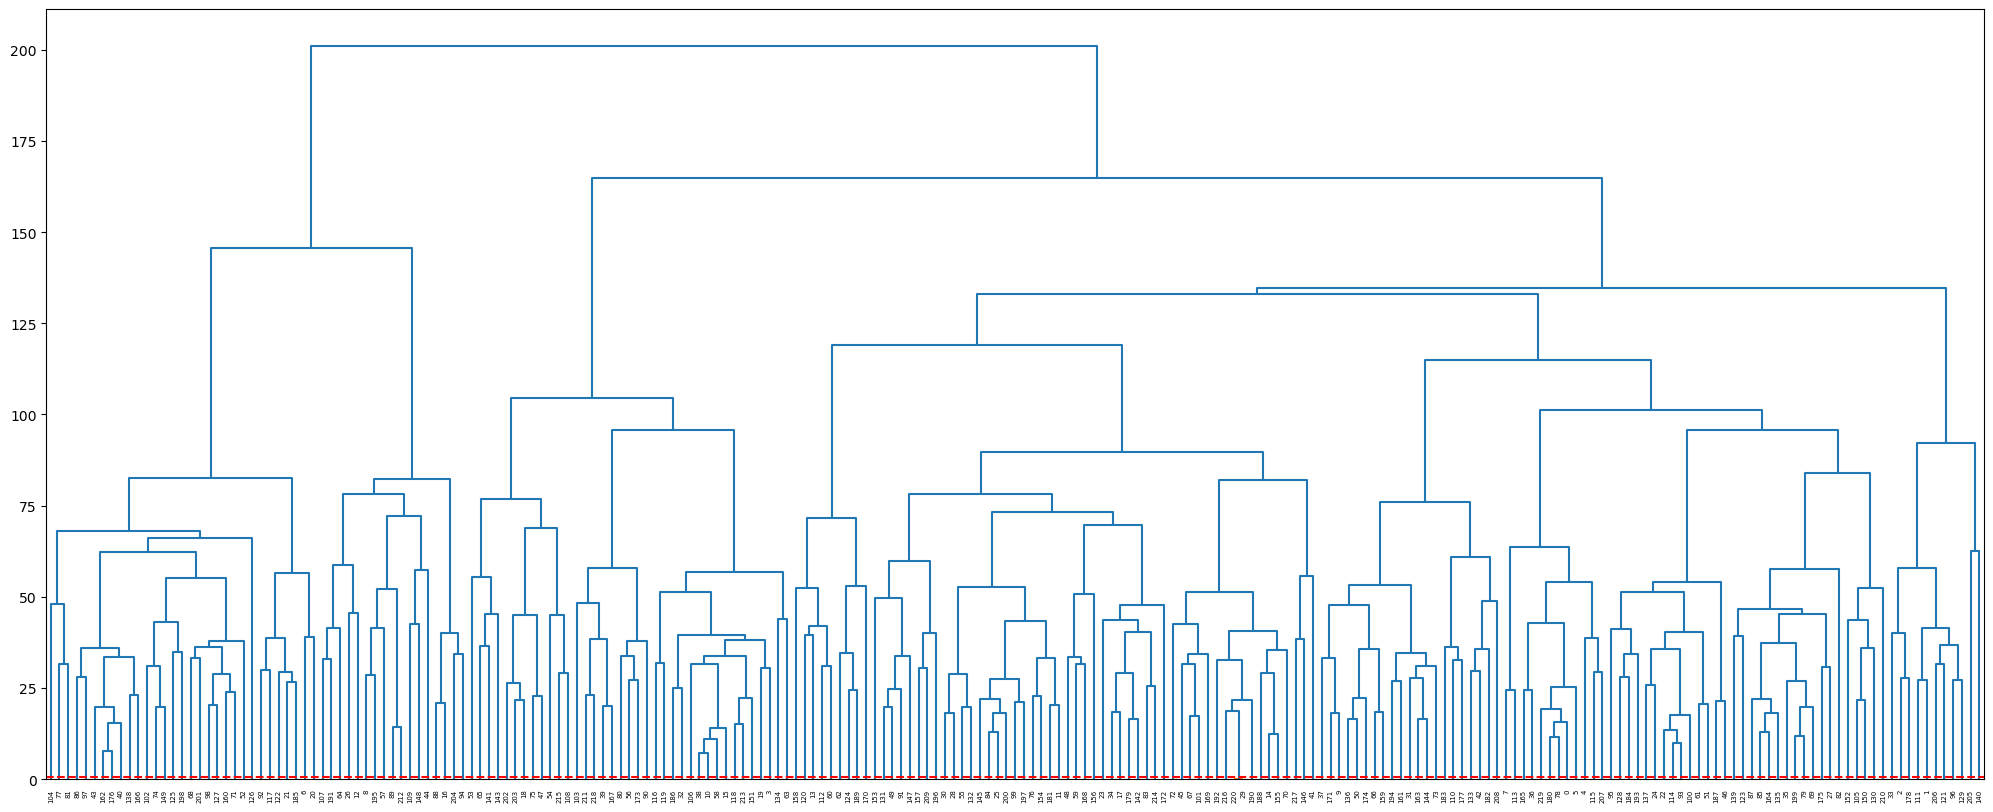

In [87]:
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(gene_cluster_cd_deep, color_threshold = 0.7)
plt.axhline(y=.7, c='r', linestyle='--')

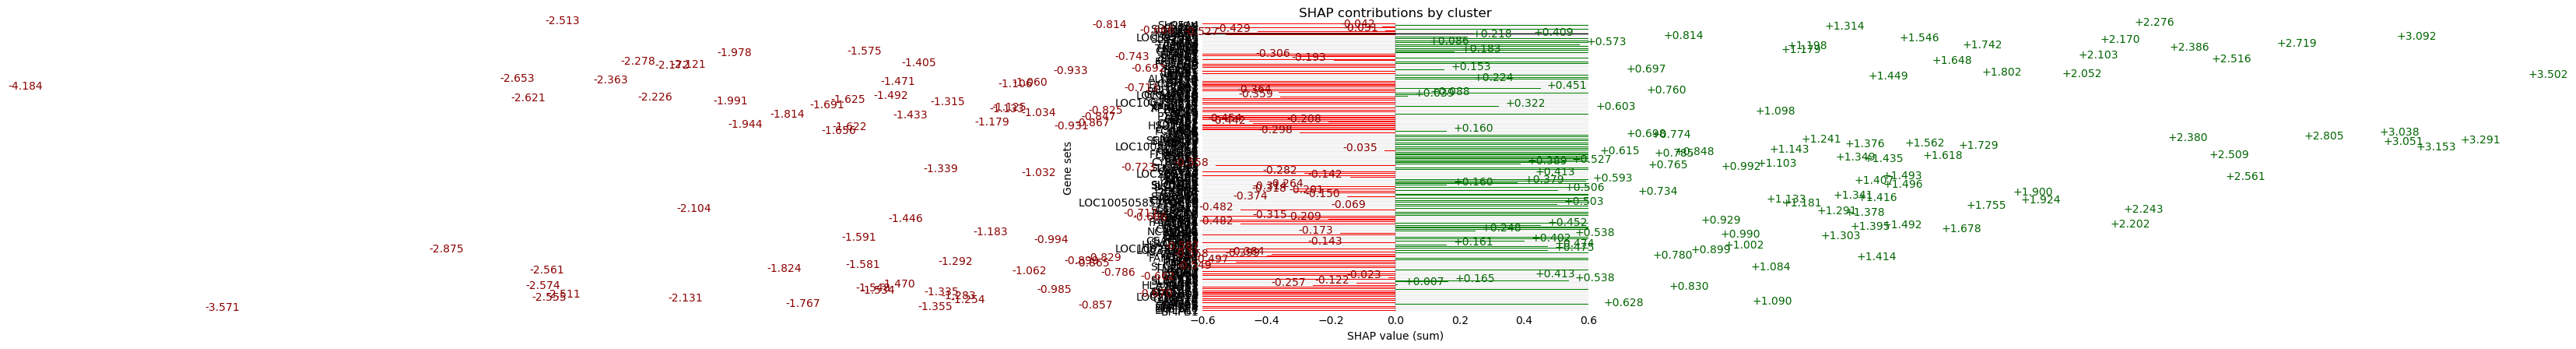

In [88]:
agg_df.plot.barh(x="cluster_labels", y="sum", legend=None, zorder=2, color=(agg_df['sum'] > 0).map({True: 'g',False: 'r'}))

plt.title('SHAP contributions by cluster')
plt.ylabel('Gene sets')
plt.xlabel('SHAP value (sum)')
plt.xlim((-.6,.6))
for i, v in enumerate(agg_df["sum"]):
    v = np.round(v, 3)
    vt = "+{:.3f}".format(v) if v >= 0 else "{:.3f}".format(v)
    offset = -.13 if v < 0 else .02
    colour = 'darkred' if v < 0 else 'darkgreen'
    plt.text(v + offset, i + .08, vt, color=colour, zorder=3)
    plt.axhline(i,linewidth=.07, color='k', zorder=1, linestyle='--')
    
    
plt.axvline(0,linewidth=.2, color='k')
plt.axhline(7.45,linewidth=1., color='k')

plt.tick_params(axis=u'both', which=u'both',length=0)
plt.gca().invert_yaxis()
plt.box(on=False)

plt.show()

gene names shown in sorted order;
can get full lists from dataframe;
clusters correspond to above dendrogram from left to right;
can choose threshold to get more / fewer clusters

In [89]:
# export to text file

for li in agg_df["grouped_genes"]:
    print(len(li),"genes:")
    for item in li:
        print(item)
    print("----------------------")

### Example: CD no ulcer patients

In [90]:
# patient_cluster_cd_deep = linkage(df_cd_deep, 'ward', metric='euclidean', optimal_ordering=True)
gene_cluster_cd_plain = linkage(df_cd_plain.T, 'ward', metric='euclidean', optimal_ordering=True)

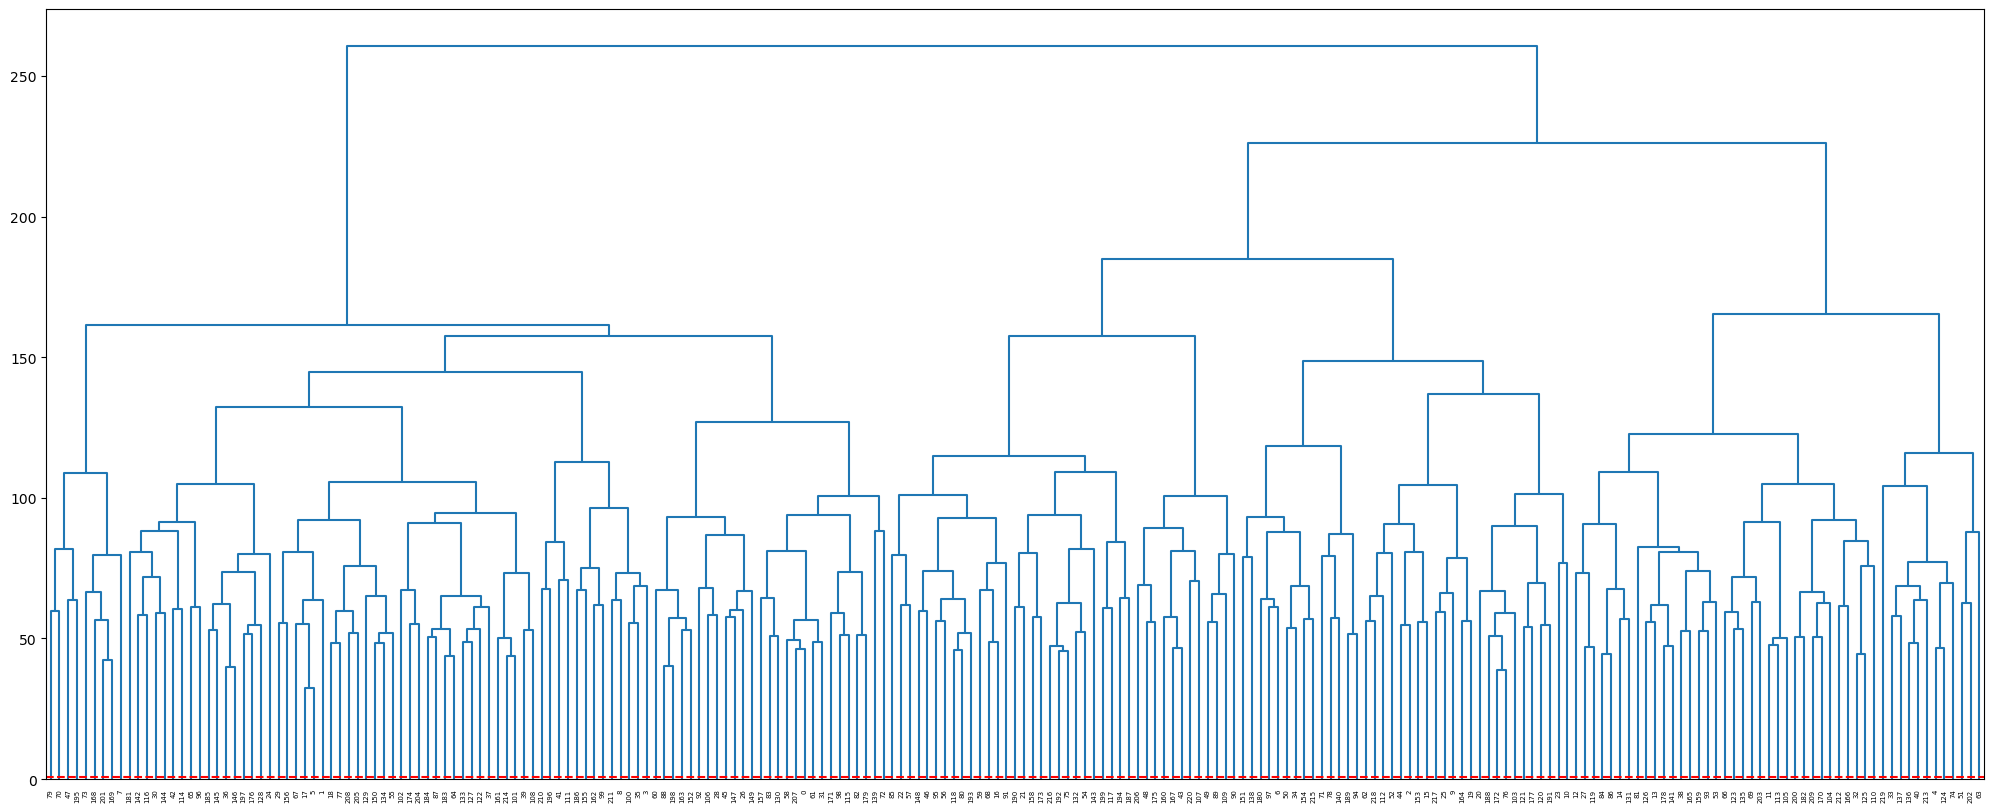

In [91]:

fig = plt.figure(figsize=(25, 10))
dn = dendrogram(gene_cluster_cd_plain, color_threshold = .8)
# dn = dendrogram(fl)
plt.axhline(y=.7, c='r', linestyle='--')

In [92]:
dn_ids = np.asarray(dn['ivl'], dtype='int')
dn_ids

array([ 79,  70,  47, 195,  73, 168, 201, 169,   7, 181, 142, 116,  30,
       144,  42, 114,  65,  96, 185, 145,  36, 146, 197, 176, 128,  24,
        29, 156,  67,  17,   5,   1,  18,  77, 208, 205, 129, 150, 134,
        55, 102, 174, 204, 184,  87, 183,  64, 133, 127, 122,  37, 161,
       214, 101,  39, 108, 210, 196,  41, 111, 186, 155, 162,  99, 211,
         8, 100,  35,   3,  60,  88, 198, 163, 152,  92, 106,  28,  45,
       147,  26, 149, 157,  83, 130,  58, 207,   0,  61,  31, 171,  98,
       115,  82, 179, 139,  72,  85,  22,  57, 148,  46,  95,  56, 118,
        80, 193,  59,  68,  16,  91, 190,  21, 158, 173, 216, 192,  75,
       132,  54, 143, 199, 117, 194, 187, 206,  48, 175, 160, 167,  43,
       220, 107,  49,  89, 109,  90, 151, 138, 180,  97,   6,  50,  34,
       154, 215,  71,  78, 140, 189,  94,  62, 218, 112,  52,  44,   2,
       153,  15, 217,  25,   9, 164,  19,  20, 188, 172,  76, 103, 121,
       177, 120, 191,  23,  10,  12,  27, 119,  84,  86,  14, 13

In [93]:
df_cd_plain.columns

Index(['AADAC', 'APOA1', 'APOA4', 'APOB', 'APOC3', 'AQP9', 'C6', 'CEACAM7',
       'CHI3L1', 'ABCC2',
       ...
       'PPP1R17', 'WNT8A', 'LSM5', 'PCDHB3', 'GUSBP11', 'C16orf78', 'C5orf17',
       'LOC100132831', 'LOC100288778', 'LOC100505851'],
      dtype='object', length=221)

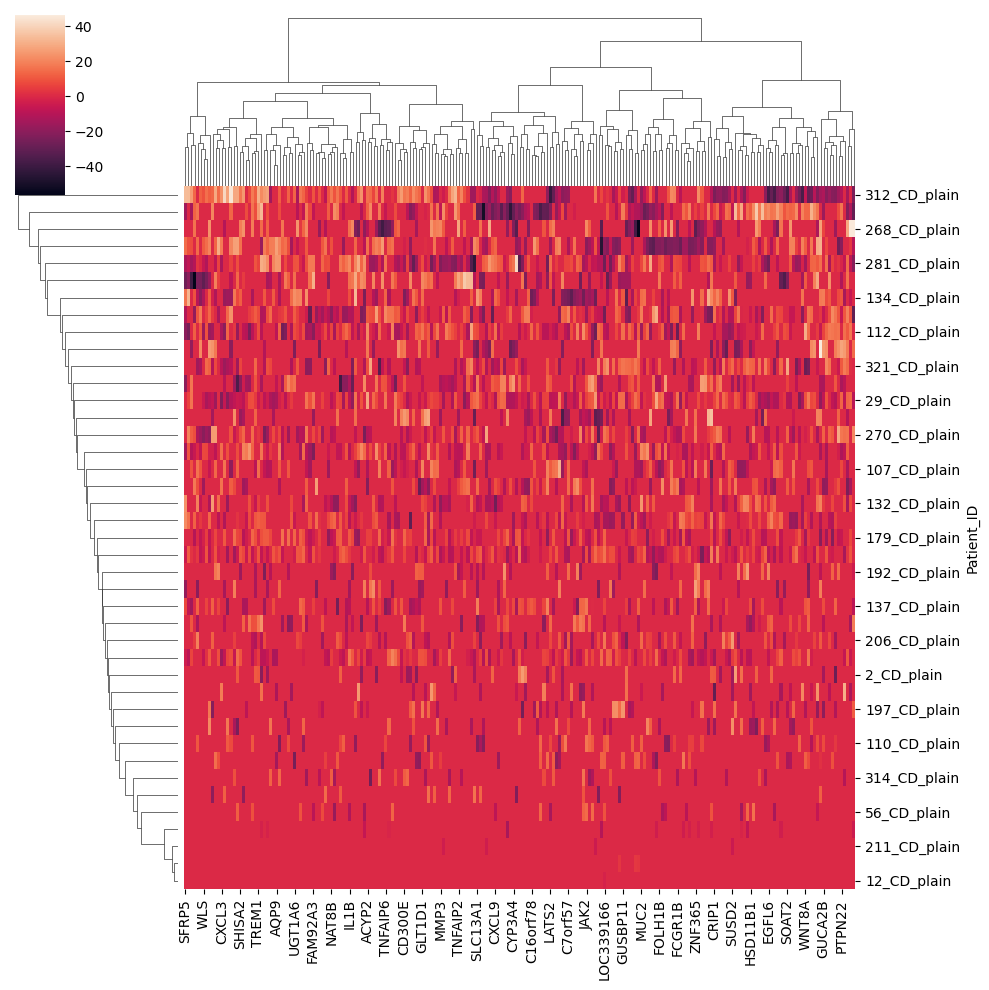

In [94]:
# shap values across genes (CD deep ulcer) - shows contribution of genes to disease symptom prediction for patients with given symptoms

# g = sns.clustermap(df_cd_deep, col_linkage=gc, row_linkage=patient_cluster_cd_deep)
g = sns.clustermap(df_cd_plain, col_linkage=gene_cluster_cd_plain)

## Aggregate bar plot, showing potential gene modules alongside SHAP contributions

In [95]:
gene_cluster_cd_plain

array([[ 17.        ,   5.        ,  32.2432971 ,   2.        ],
       [172.        ,  76.        ,  38.74208514,   2.        ],
       [ 36.        , 146.        ,  39.91458607,   2.        ],
       [ 88.        , 198.        ,  40.34823995,   2.        ],
       [201.        , 169.        ,  42.45422733,   2.        ],
       [183.        ,  64.        ,  43.75306277,   2.        ],
       [214.        , 101.        ,  43.88869832,   2.        ],
       [ 32.        , 125.        ,  44.38751578,   2.        ],
       [ 84.        ,  86.        ,  44.61865469,   2.        ],
       [192.        ,  75.        ,  45.64974472,   2.        ],
       [118.        ,  80.        ,  45.73247635,   2.        ],
       [207.        ,   0.        ,  46.17399691,   2.        ],
       [  4.        , 124.        ,  46.45947029,   2.        ],
       [167.        ,  43.        ,  46.66509489,   2.        ],
       [ 27.        , 119.        ,  46.83316946,   2.        ],
       [178.        , 141

In [96]:
cluster_labels = fcluster(gene_cluster_cd_plain, .8, criterion='distance')
# cluster_labels = fcluster(gene_cluster_cd_plain, 8, criterion='maxclust')
cluster_labels.shape

(221,)

In [97]:
leaders(gene_cluster_cd_plain, cluster_labels)

(array([ 79,  70,  47, 195, 201, 169, 168,  73,   7, 142, 116,  30, 144,
        181,  42, 114,  65,  96, 185, 145,  36, 146, 197, 176, 128,  24,
         29, 156,  17,   5,  67,   1,  18,  77, 208, 205, 150, 134,  55,
        129, 174, 204, 102, 184,  87, 183,  64, 133, 127, 122,  37, 214,
        101, 161,  39, 108, 210, 196,  41, 111, 186, 155, 162,  99, 211,
          8, 100,  35,   3,  88, 198, 163, 152,  60, 106,  28,  92,  45,
        147,  26, 149,  83, 130, 157, 207,   0,  58,  61,  31,  98, 115,
        171,  82, 179, 139,  72,  22,  57,  85, 148,  46,  95,  56, 118,
         80, 193,  68,  16,  59,  91, 190,  21, 158, 173, 192,  75, 216,
        132,  54, 143, 199, 117, 194, 187,  48, 175, 206, 167,  43, 160,
        220, 107,  49,  89, 109,  90, 151, 138,  97,   6, 180,  50,  34,
        154, 215,  78, 140,  71, 189,  94,  62, 218, 112,  52,  44,   2,
        153,  15, 217,  25,   9, 164,  19, 172,  76, 188, 103,  20, 121,
        177, 120, 191,  23,  10,  27, 119,  12,  84

In [98]:
leader_ids = leaders(gene_cluster_cd_plain, cluster_labels)[1]
leader_ids

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [99]:
cluster_labels

array([ 86,  32, 156,  69, 215,  30, 140,   9,  66, 161, 174, 197, 177,
       183, 180, 158, 108,  29,  33, 163, 168, 112,  97, 173,  26, 160,
        80, 175,  76,  27,  12,  89, 207, 210, 143,  68,  21,  51, 186,
        55, 213,  59,  15, 129, 155,  78, 101,   3, 125, 133, 142, 219,
       154, 190, 119,  39, 103,  98,  87, 109,  74,  88, 151, 221,  47,
        17, 194,  31, 107, 195,   2, 148,  96,   8, 217, 116, 165,  34,
       146,   1, 105, 191,  93,  82, 178,  99, 179,  45,  70, 134, 136,
       110,  77, 189, 150, 102,  18, 139,  90,  64,  67,  53,  43, 167,
       204, 199,  75, 132,  56, 135, 209,  60, 153, 198,  16,  91,  11,
       122, 104, 176, 171, 169,  50, 192, 216, 208, 182,  49,  25,  40,
        83, 181, 118,  48,  38, 193, 212, 211, 138,  95, 147, 185,  10,
       120,  13,  20,  22,  79, 100,  81,  37, 137,  73, 157, 144,  62,
        28,  84, 113, 188, 130,  54,  63,  72, 162, 187, 206, 128,   7,
         6, 203,  92, 164, 114,  41, 126,  24, 170, 184,  94, 14

In [100]:
gene_df = df_cd_plain.describe().T
gene_df['gene_symbol']  = df_cd_plain.columns
gene_df["group_num"] = cluster_labels

gene_df

,count,mean,std,min,25%,50%,75%,max,gene_symbol,group_num
AADAC,41.0,-1.284318,6.070937,-18.786797,0.0,0.0,0.000000,18.170451,AADAC,86
APOA1,41.0,2.193659,8.777561,-22.399373,0.0,0.0,7.041943,24.346773,APOA1,32
APOA4,41.0,-1.232637,10.345234,-24.217802,0.0,0.0,0.000000,29.734498,APOA4,156
APOB,41.0,1.944535,8.706872,-18.881445,0.0,0.0,0.000000,19.815804,APOB,69
APOC3,41.0,1.805921,8.936260,-26.810807,0.0,0.0,0.000000,28.840709,APOC3,215
...,...,...,...,...,...,...,...,...,...,...
C16orf78,41.0,0.366425,5.973267,-27.403140,0.0,0.0,0.000000,13.380366,C16orf78,117
C5orf17,41.0,-1.021087,9.214560,-27.867843,0.0,0.0,0.000000,25.749133,C5orf17,159
LOC100132831,41.0,0.401961,8.544033,-28.575705,0.0,0.0,0.000000,17.318512,LOC100132831,152
LOC100288778,41.0,2.904912,13.238903,-21.037395,0.0,0.0,3.198962,46.522301,LOC100288778,218


In [101]:
# mean_df = gene_df[['mean','group_num']]
mean_df = gene_df[['mean','group_num','gene_symbol']]
mean_df

,mean,group_num,gene_symbol
AADAC,-1.284318,86,AADAC
APOA1,2.193659,32,APOA1
APOA4,-1.232637,156,APOA4
APOB,1.944535,69,APOB
APOC3,1.805921,215,APOC3
...,...,...,...
C16orf78,0.366425,117,C16orf78
C5orf17,-1.021087,159,C5orf17
LOC100132831,0.401961,152,LOC100132831
LOC100288778,2.904912,218,LOC100288778


In [102]:

mean_df["gene_symbol"] = mean_df.index
mean_df


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,mean,group_num,gene_symbol
AADAC,-1.284318,86,AADAC
APOA1,2.193659,32,APOA1
APOA4,-1.232637,156,APOA4
APOB,1.944535,69,APOB
APOC3,1.805921,215,APOC3
...,...,...,...
C16orf78,0.366425,117,C16orf78
C5orf17,-1.021087,159,C5orf17
LOC100132831,0.401961,152,LOC100132831
LOC100288778,2.904912,218,LOC100288778


In [103]:
agg_df = mean_df.groupby(['group_num'])
agg_df = agg_df.apply(group_fn)
agg_df

,sum,gene_count,grouped_genes
group_num,,,
1,-0.711119,1,[SFRP5]
2,1.652516,1,[S100A8]
3,-0.073073,1,[IL12B]
4,0.123224,1,[EFNB1]
5,-2.257331,1,[WLS]
...,...,...,...
217,1.169620,1,[SAA2]
218,2.904912,1,[LOC100288778]
219,1.888564,1,[LCN2]


In [104]:

# agg_df = mean_df.groupby(['group_num']).agg(sum=('mean','sum'), 
#       gene_count=('mean','count'), grouped_genes=('gene_symbol', 'mean', test))
# result = result.rename(columns={'categorize' : 'Buy/Sell'})
agg_df["cluster_labels"] = agg_df["grouped_genes"].apply(group_labels)
# agg_df["cluster_labels"] = agg_df["count"].apply(add_other)

agg_df['cluster_labels'] = agg_df.apply(lambda x: add_other(x["gene_count"], x["cluster_labels"]), axis=1)
agg_df

,sum,gene_count,grouped_genes,cluster_labels
group_num,,,,
1,-0.711119,1,[SFRP5],SFRP5
2,1.652516,1,[S100A8],S100A8
3,-0.073073,1,[IL12B],IL12B
4,0.123224,1,[EFNB1],EFNB1
5,-2.257331,1,[WLS],WLS
...,...,...,...,...
217,1.169620,1,[SAA2],SAA2
218,2.904912,1,[LOC100288778],LOC100288778
219,1.888564,1,[LCN2],LCN2


In [105]:
sorted_idxs = get_idx_order(dn_ids, df_cd_plain, agg_df)

In [106]:
# agg_df.index = leader_ids
agg_df.index = sorted_idxs
agg_df

,sum,gene_count,grouped_genes,cluster_labels
1,-0.711119,1,[SFRP5],SFRP5
2,1.652516,1,[S100A8],S100A8
3,-0.073073,1,[IL12B],IL12B
4,0.123224,1,[EFNB1],EFNB1
8,-2.257331,1,[WLS],WLS
...,...,...,...,...
216,1.169620,1,[SAA2],SAA2
217,2.904912,1,[LOC100288778],LOC100288778
219,1.888564,1,[LCN2],LCN2
220,1.072544,1,[GRAMD1A],GRAMD1A


In [107]:
agg_df = agg_df.sort_index()
agg_df

,sum,gene_count,grouped_genes,cluster_labels
1,-0.711119,1,[SFRP5],SFRP5
2,1.652516,1,[S100A8],S100A8
3,-0.073073,1,[IL12B],IL12B
4,0.123224,1,[EFNB1],EFNB1
5,-0.648593,1,[MUC5B],MUC5B
...,...,...,...,...
217,2.904912,1,[LOC100288778],LOC100288778
218,-0.803976,1,[GUCA2B],GUCA2B
219,1.888564,1,[LCN2],LCN2
220,1.072544,1,[GRAMD1A],GRAMD1A


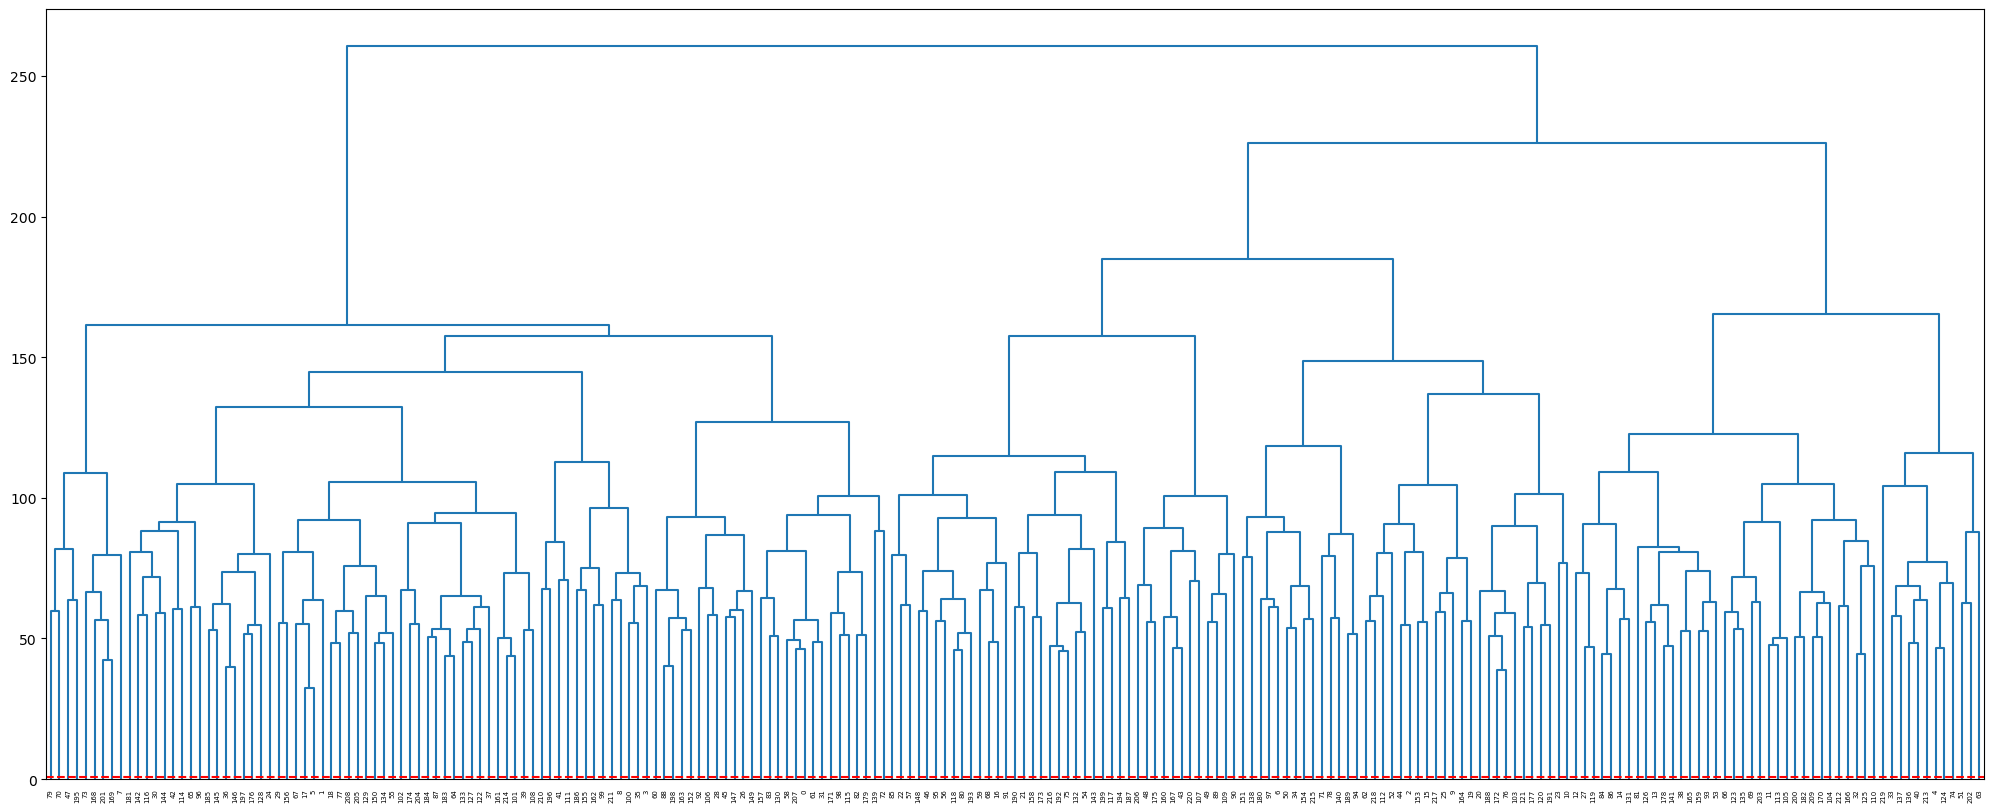

In [108]:
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(gene_cluster_cd_plain, color_threshold=.8, get_leaves=True)
plt.axhline(y=.8, c='r', linestyle='--')

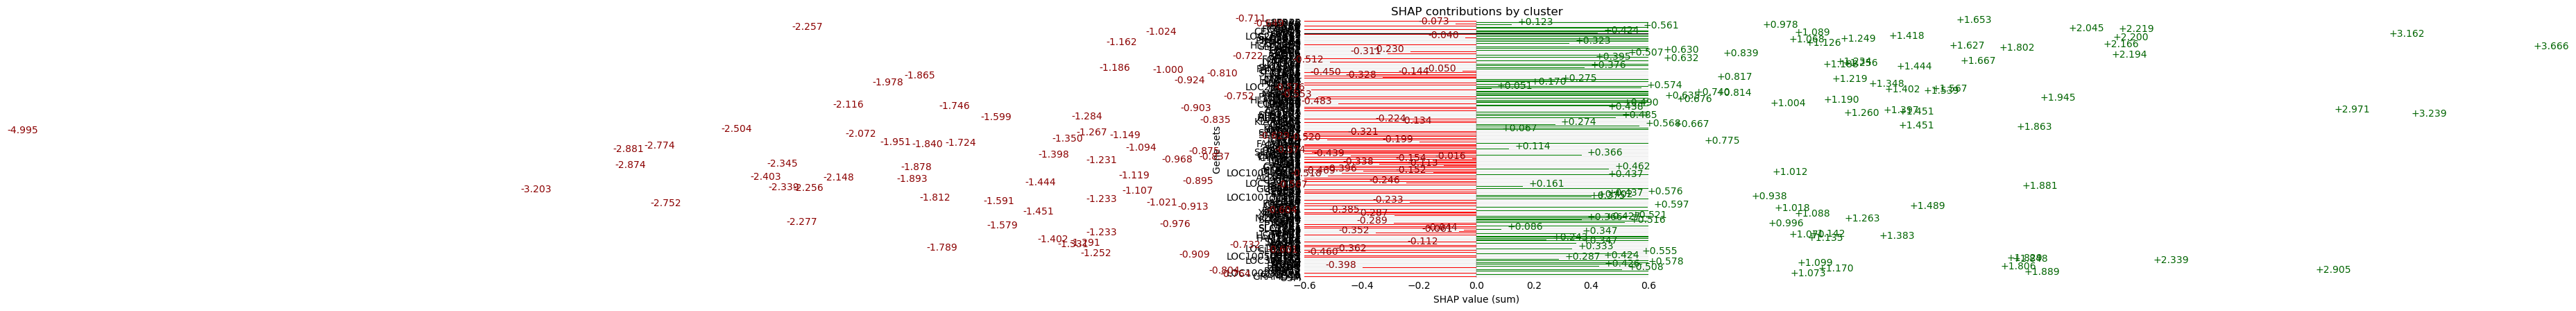

In [109]:
agg_df.plot.barh(x="cluster_labels", y="sum", legend=None, zorder=2, color=(agg_df['sum'] > 0).map({True: 'g',False: 'r'}))

plt.title('SHAP contributions by cluster')
plt.ylabel('Gene sets')
plt.xlabel('SHAP value (sum)')
plt.xlim((-.6,.6))
for i, v in enumerate(agg_df["sum"]):
    v = np.round(v, 3)
    vt = "+{:.3f}".format(v) if v >= 0 else "{:.3f}".format(v)
    offset = -.13 if v < 0 else .02
    colour = 'darkred' if v < 0 else 'darkgreen'
    plt.text(v + offset, i + .08, vt, color=colour, zorder=3)
    plt.axhline(i,linewidth=.07, color='k', zorder=1, linestyle='--')
    
    
plt.axvline(0,linewidth=.2, color='k')
size = fig.get_size_inches()[1]
plt.axhline(size + .045*size,linewidth=.9, color='k')

plt.tick_params(axis=u'both', which=u'both',length=0)
plt.gca().invert_yaxis()
plt.box(on=False)

plt.show()

gene names shown in sorted order;
can get full lists from dataframe
clusters correspond to above dendrogram from left to right
can choose threshold to get more / fewer clusters

In [110]:
# export to text file

for li in agg_df["grouped_genes"]:
    print(len(li),"genes:")
    for item in li:
        print(item)
    print("----------------------")